<a href="https://colab.research.google.com/github/kruthikagangaraju/Machine-Learning/blob/main/Bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_point", "radiation", "rainfall", "snowfall", "functional"]
#df = pd.read_csv("SeoulBikeData.csv", encoding='latin-1')
df = pd.read_csv("SeoulBikeData.csv", encoding='latin-1').drop(["Date", "Holiday", "Seasons"], axis=1)


In [4]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_point,radiation,rainfall,snowfall,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


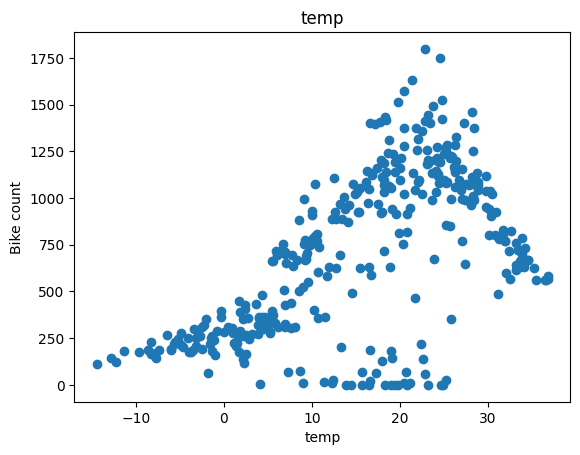

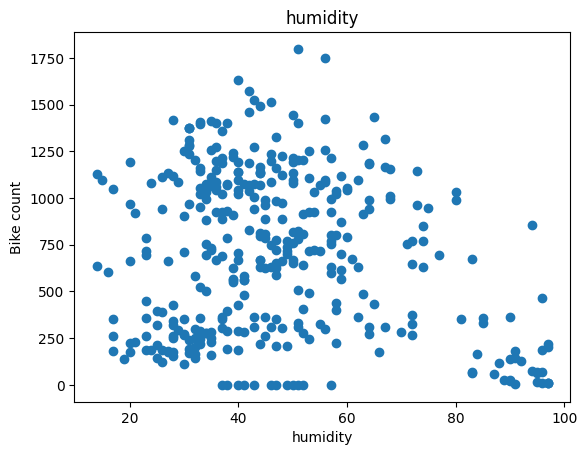

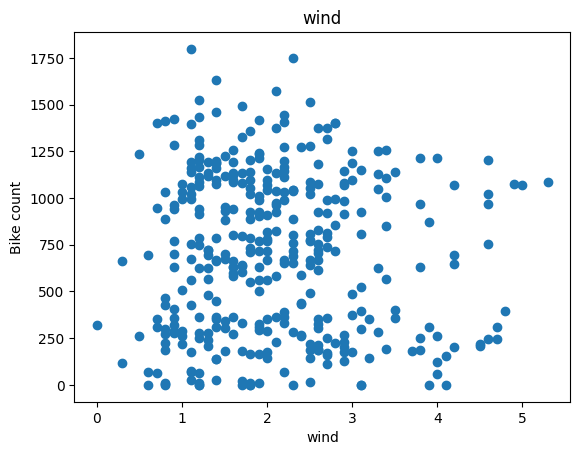

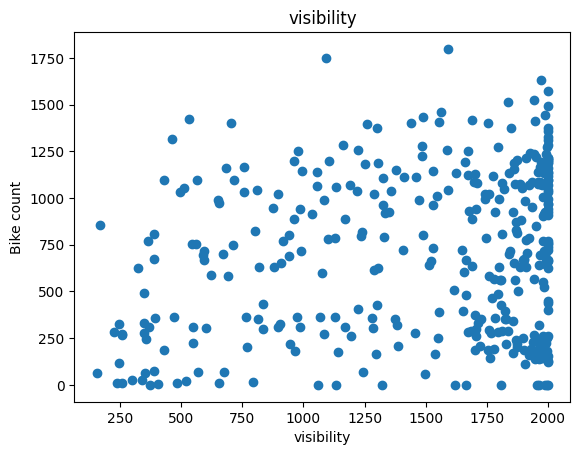

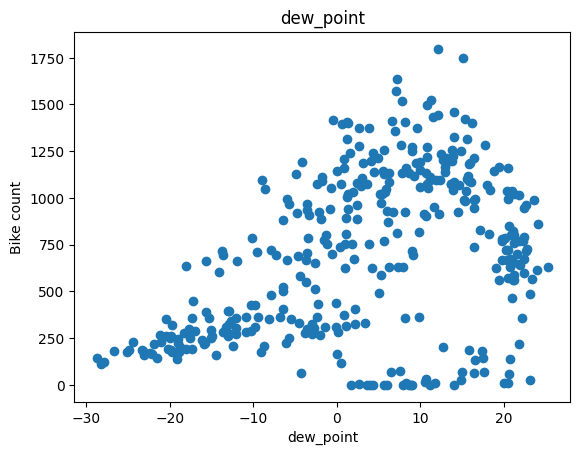

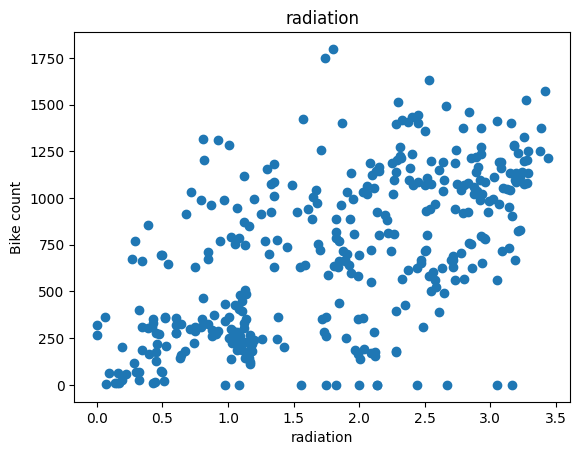

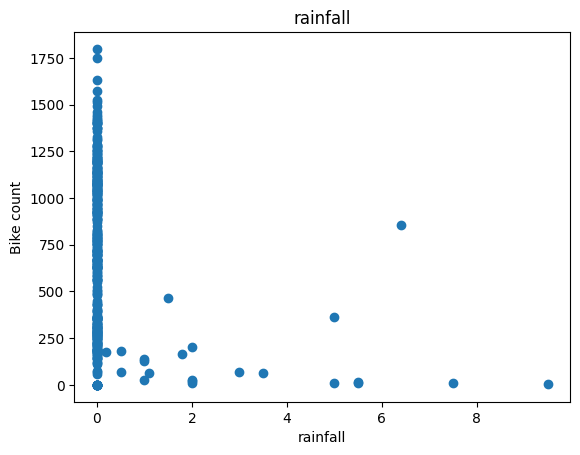

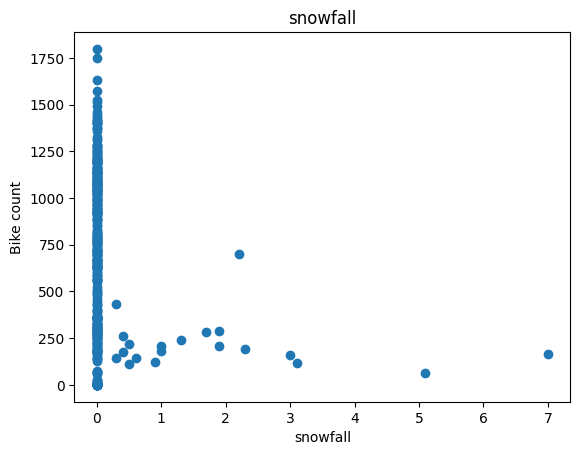

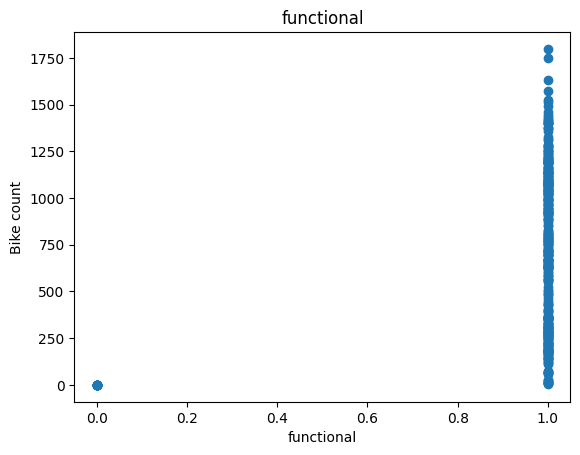

In [5]:
for label in df.columns[1:]:
  plt.figure()
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike count")
  plt.xlabel(label)
  plt.draw()
  plt.pause(0.001)  # Pause to allow the plot to render
  plt.show()

In [6]:
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_point,radiation,rainfall,snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


Single Linear Regression

In [7]:
def get_xy(dataframe, y_label, x_label=None):
  dataframe = copy.deepcopy(dataframe)
  if not x_label:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_label) == 1:
      X = dataframe[[x_label[0]]].values.reshape(-1, 1)
    else:
      X = dataframe[x_label].values
  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))
  return data, X, y

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_label=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_label=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_label=["temp"])

In [9]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)
temp_reg.score(X_test_temp, y_test_temp)

0.28128534324863164

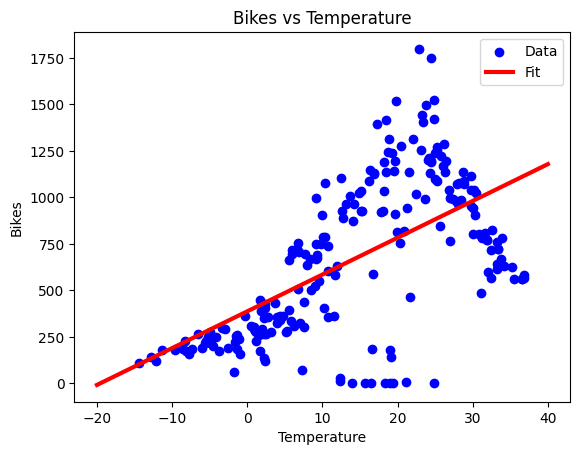

In [10]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bikes")
plt.show()

Multiple Linear Regression

In [11]:
def get_xy(dataframe, y_label, x_label=None):
  dataframe = copy.deepcopy(dataframe)
  if x_label is None or x_label.empty:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_label) == 1:
      X = dataframe[[x_label[0]]].values.reshape(-1, 1)
    else:
      X = dataframe[x_label].values
  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))
  return data, X, y

In [12]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train, y_train = get_xy(train, "bike_count", x_label=df.columns[1:])
_, X_val, y_val = get_xy(val, "bike_count", x_label=df.columns[1:])
_, X_test, y_test = get_xy(test, "bike_count", x_label=df.columns[1:])

In [13]:
all_reg = LinearRegression()
all_reg.fit(X_train, y_train)
all_reg.score(X_test, y_test)

0.39066020716152416

Regression with Neural Network

In [14]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [15]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])
#temp_nn_model.summary()

In [16]:
temp_nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

In [17]:
def plot_loss(history):
  #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  #ax1.legend()
  plt.grid(True)
  plt.show()

In [18]:
history = temp_nn_model.fit(X_train_temp.reshape(-1), y_train_temp, epochs=1000, validation_data=(X_val_temp, y_val_temp), verbose=0)

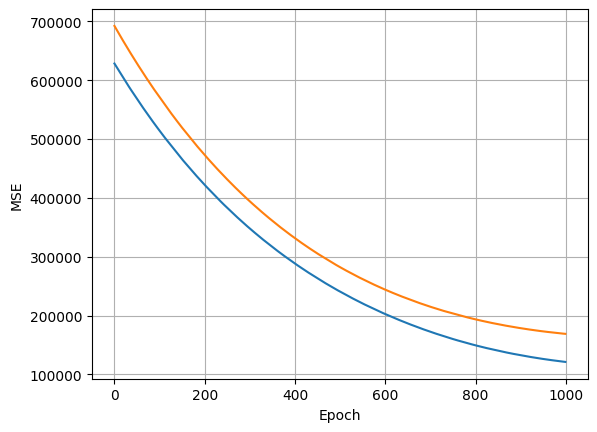

In [19]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


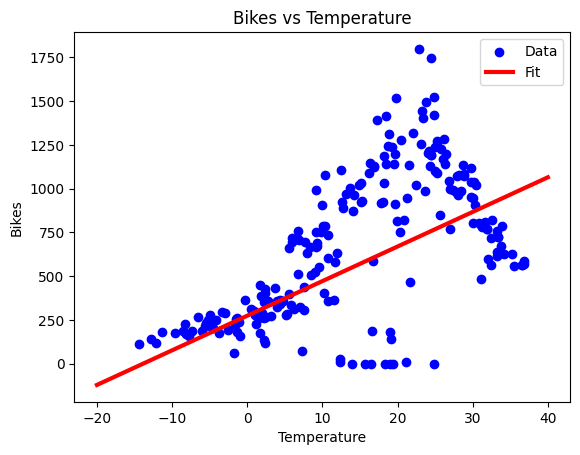

In [20]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bikes")
plt.show()

Neural Network

In [25]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [26]:
history = nn_model.fit(X_train_temp, y_train_temp, validation_data=(X_val_temp, y_val_temp), epochs=100, verbose=0)

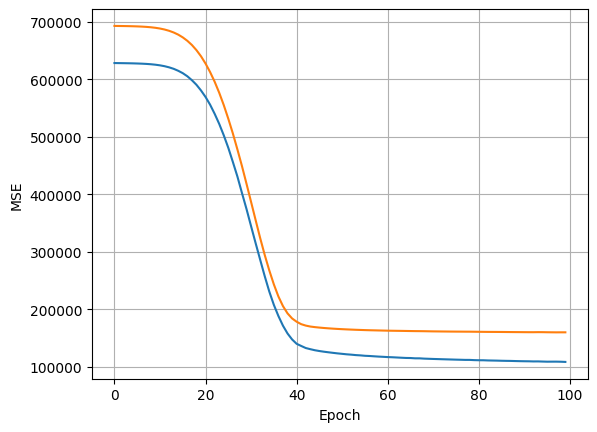

In [27]:
plot_loss(history)

4/4 [==============================] - 0s 3ms/step


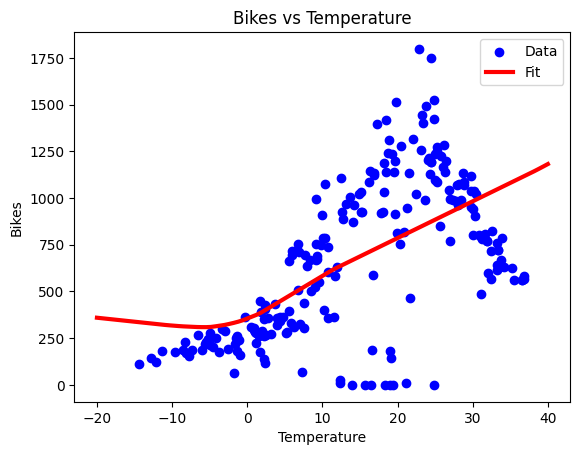

In [28]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bikes")
plt.show()